# Foundations of CSS Final Group Project: *Question Goes Here*

TODO: Add link to research poster and report

## Prerequisits

### Install Dependencies

In [87]:
# ATTENTION: pycaret needs PYTHON VERSION 3.11. OR LOWER
!pip install pyreadstat pandas numpy matplotlib wbgapi scipy pycaret seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import shutil
import re
import wbgapi as wb
import pycaret as pc
import pycaret.regression as reg
import scipy as sp
from scipy import stats
import seaborn as sns

### Decompress Data

In [3]:
with zipfile.ZipFile("data.zip", "r") as zip_ref:
    zip_ref.extractall("data")
 
# For data changes, re-zip data to zip file with python:
# shutil.make_archive("data", 'zip', "data")
# or in the shell with command `zip data.zip data/ -9 -r` (linux)


### Load and Prepare Data

#### Attitudes Data


International Social Survey Programme: Environment I-IV Cumulation. \
ISSP Research Group (2024) \
GESIS, Cologne. \
ZA8793 Data file Version 1.0.0 \
https://doi.org/10.4232/1.14332

See [terms of use](https://www.gesis.org/fileadmin/upload/dienstleistung/daten/umfragedaten/_bgordnung_bestellen/2023-06-30_Nutzungsbedingungen.pdf) (category A) for more information.

The survey data is used in [Long-run trends in partisan polarization of climate policy-relevant attitudes across countries](https://doi.org/10.1080/09644016.2024.2403957) as well which we partly reproduce here.

In [4]:
survey_data_raw_df = pd.read_stata("data/ZA8793_v1-0-0_survey.dta")

There are 145 columns in the dataset.
In the following, we make a selection of relevant ones
and additionally group certain questions into
"support for public" vs "support for individual" action.

In [5]:
# Define mapping functions to support getting survey data in usable format

def extract_integer(x):
    if (type(x) == int): return x
    if (type(x) == float): return int(x)

    return int(x.split('.')[0]) # assuming format like 2. agree somewhat

# The below functions are helpers to make mapping the liker-scale responses (1.-5. (agree or disagree) or 1-4).
# The responses are stretched to values between -2 and 2.
# See in the next cell how it's used.
def likert_scale_to_float(input, invert: bool, shift: float):
    int_val = extract_integer(input)
    if int_val < 0:
        return np.nan;
    else:
        return float(int_val) + shift if invert == False else (float(int_val) + shift) * -1

def likert_scale_to_float_5(input):
    val = likert_scale_to_float(input, invert=False, shift=-3)
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_invert_5(input):
    val = likert_scale_to_float(input, invert=False, shift=-3)
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_invert_4(input, shift=-2.5):
    val = likert_scale_to_float(input, invert=True, shift=shift) * 4/3
    return val if val >= -2 and val <= 2 else np.nan

def likert_scale_to_float_4(input, invert=False):
    val = likert_scale_to_float(input, invert, shift=-2.5) * 4/3
    return val if val >= -2 and val <= 2 else np.nan



In [6]:
# Comments beginning with letters (abcd) indicate which study have the question, if not all (1993, 2000, 2010, 2020).
# Some mapping comments contain the exact question asked in the survey.
# Detailed explanation of variables can be found here: https://search.gesis.org/research_data/ZA8793#variables|exploredata-ZA8793_VarWRKHRS|0|variable_order|asc

# The below mapping is used to rename the original column names
# and define functions to convert the columns, if necessary.
# Not all of the dataset's questions are mapped (and kept).
# Those are all that seemed vaguely interesting
# but for the main analysis we only consider a subset.
mapping = {
  "cumu_id": {  "name": 'id',
                "mapper": int },
  "year": {     "name": 'year',
                "mapper": extract_integer },
  "country": {  "name": 'country_iso2',
                "mapper": lambda country: re.search(r'^\d+\. ([A-Z]+)-', country).group(1) },
  "AGE": {      "name": 'age',
                "mapper": extract_integer },
  "SEX": {      "name": 'sex',
                "mapper": None },
  "EDUCYRS": {  "name": 'education_years',
                "mapper": lambda year: extract_integer(year) if extract_integer(year) < 30 else -2 },
  'MARITAL': {  "name": 'marital_status',
                "mapper": None },
  "PARTY_LR1": {"name": 'party_lef_right_derived',
                "mapper": likert_scale_to_float_5 },
  "PARTY_LR2": {"name": 'party_lef_right_asked',
                "mapper": likert_scale_to_float_5 },
  "WEIGHT": {   "name": 'regional_weight_factor',
                "mapper": lambda w: 1 if w == "1. No weighting" else w },

  "v11": {      "name": 'science_solves_env_problems',
                "mapper": likert_scale_to_float_invert_5 },
  "v12": {      "name": 'worry_too_much_about_env_not_prices_jobs',
                "mapper": likert_scale_to_float_invert_5 },
  "v13": {      "name": 'modern_life_harms_env',
                "mapper": likert_scale_to_float_5 },
  "v14": {      "name": 'ppl_worry_too_much_progress_harms_env', 
                "mapper": likert_scale_to_float_5 }, # People worry too much about human progress harming the environment.
  "v15": {      "name": 'env_needs_econ_growth',
                "mapper": likert_scale_to_float_5 }, # In order to protect the environment [COUNTRY] needs economic growth.
  "v17": {      "name": 'econ_growth_harms_env',
                "mapper": likert_scale_to_float_5 },
  "v18": {      "name": 'population_growth_unsustainable',
                "mapper": likert_scale_to_float_5 },
  "v20": {      "name": 'support_indiv_pay_more',
                "mapper":  likert_scale_to_float_invert_5},
  "v21": {      "name": 'support_pay_higher_taxes',
                "mapper": likert_scale_to_float_invert_5 },
  "v22": {      "name": 'support_cut_living_standards',
                "mapper": likert_scale_to_float_invert_5 },
  "v23": {      "name": 'indiv_action_too_difficult',
                "mapper": likert_scale_to_float_invert_5 }, # It is just too difficult for someone like me to do much about the environment.
  "v24": {      "name": 'indiv_support_sacrifice',
                "mapper": likert_scale_to_float_invert_5 }, # I do what is right for the environment, even when it costs more money or takes more time.
  "v26": {      "name": 'support_only_with_others',
                "mapper": likert_scale_to_float_5 }, # bcd; There is no point in doing what I can for the environment unless others do the same.
  "v27": {      "name": 'threats_not_exaggerated',
                "mapper": likert_scale_to_float_5 }, # bcd
  "v33": {      "name": 'climate_change_no_hole_atmosphere',
                "mapper": likert_scale_to_float_4 }, # abc, Climate change [/ greenhouse effect] is caused by a hole in the earth's atmosphere. (afterwards inverted)
  "v34": {      "name": 'climate_change_oil_gas',
                "mapper": likert_scale_to_float_invert_4 }, # abc, Every time we use coal or oil or gas, we contribute to climate change [/ greenhouse effect].
  "v35": {      "name": 'env_problems_everyday_life',
                "mapper": likert_scale_to_float_invert_5 }, # cd
  "v36": {      "name": 'car_air_poll_danger_env',
                "mapper": likert_scale_to_float_invert_5 }, # Air pollution caused by cars is (dangerous/ not dangerous) for environment
  "v37": {      "name": 'car_air_poll_danger_indiv',
                "mapper": likert_scale_to_float_invert_5 }, # Air pollution caused by cars is (dangerous/ not dangerous) for you and your family
  "v39": {      "name": 'industry_air_poll_danger_env',
                "mapper": likert_scale_to_float_invert_5 }, # In general, do you think that air pollution caused by industry is (dangerous/ not dangerous)
  "v42": {      "name": 'temp_rise_danger_env',
                "mapper": likert_scale_to_float_invert_5 }, # bcd In general, do you think that a rise in the world's temperature caused by climate change is (dangerous/ not dangerous)
  "v44": {      "name": 'gov_laws_not_indiv',
                "mapper": lambda val: 1 if extract_integer(val) == 2 else 0 }, # abc Government or ordinary people: decide themselves how to protect environment (2 = government)
  "v45": {      "name": 'gov_laws_not_business',
                "mapper": lambda val: 1 if extract_integer(val) == 2 else 0 }, # abc Government or business: decide themselves how to protect environment
  "v47": {      "name": 'internation_agreement_support',
                "mapper": likert_scale_to_float_invert_5 }, # bc
  "v50": {      "name": 'gov_force_business',
                "mapper": lambda val: 1 if val.startswith('1. Heavy fines') or val.startswith('2. Use the tax system') else 0 }, # cd Which of these approaches do you think would be the best way of getting business and industry in [COUNTRY] to protect the environment?
  "v50_2": {    "name": 'gov_voluntary_business',
                "mapper": lambda val: 1 if val.startswith('3. More information and education') else 0 }, # cd Which of these approaches do you think would be the best way of getting business and industry in [COUNTRY] to protect the environment?
  "v51": {      "name": 'gov_force_indiv',
                "mapper": lambda val: 1 if val.startswith('1. Heavy fines') or val.startswith('2. Use the tax system') else 0 }, # cd Which of these approaches do you think would be the best way of getting people and their families in [COUNTRY] to protect the environment?
  "v51_2": {    "name": 'gov_voluntary_indiv',
                "mapper": lambda val: 1 if val.startswith('3. More information and education') else 0 }, # cd Which of these approaches do you think would be the best way of getting people and their families in [COUNTRY] to protect the environment?
  "v52": {      "name": 'indiv_avoid_buying',
                "mapper": lambda val: likert_scale_to_float_invert_4(val) }, # cd And how often do you avoid buying certain products for environmental reasons?
  "v53": {      "name": 'indiv_sort_waste',
                "mapper": lambda val: likert_scale_to_float_invert_5(val)}, # ac How often do you make a special effort to sort glass or tins or plastic or newspapers and so on for recycling?
  "v54": {      "name": 'indiv_buy_organic',
                "mapper": lambda val: likert_scale_to_float_invert_5(val)}, # ac How often do you make a special effort to buy fruit and vegetables grown without pesticides or chemicals?
  "v55": {      "name": 'indiv_avoid_car',
                "mapper": lambda val: likert_scale_to_float_invert_5(val)}, # abc And how often do you cut back on driving a car for environmental reasons?
  "v56": {      "name": 'member_group_preserve_env',
                "mapper": lambda val: 1 if val == '1. Yes' else 0 }, # Are you a member of any group whose main aim is to preserve or protect the environment?
  "v57": {      "name": 'signed_petition',
                "mapper": lambda val: 1 if val.startswith('1. Yes') else 0 }, # In the last five years, have you signed a petition about an environmental issue?
  "v58": {      "name": 'donated_money',
                "mapper": lambda val: 1 if val.startswith('1. Yes') else 0 }, # In the last five years, Given money to an environmental group?
  "v59": {      "name": 'protest',
                "mapper": lambda val: 1 if val.startswith('1. Yes') else 0 }, # In the last five years, Taken part in a protest or demonstration about an environmental issue?
}

# We are going to use those columns twice to map to different categories (supports forced action vs supports voluntary action)
survey_data_raw_df['v50_2'] = survey_data_raw_df['v50']
survey_data_raw_df['v51_2'] = survey_data_raw_df['v51']


column_naming_map = { key: value["name"] for key, value in mapping.items() }

survey_df = survey_data_raw_df[list(column_naming_map.keys())].rename(columns=column_naming_map)

# For some columns, we need to convert responses e.g. '1. Strongly disagree' might become -2
# The conversion functions are defined in the mapping dict above.
for mapping_key in mapping.keys():
  new_key = mapping[mapping_key]["name"]
  mapping_fn = mapping[mapping_key]["mapper"]
  if mapping_fn:
    survey_df[new_key] = survey_df[new_key].map(mapping_fn)



In [21]:
# For some columns we need a human-readable label later.
column_labels = {
  'climate_change_oil_gas': "Fossils contribute to climate change",
  'modern_life_harms_env': "Modern life harms environment",
  'car_air_poll_danger_env': "Car air pollution danger for environment",
  'car_air_poll_danger_indiv': "Car air pollution danger for you/family",
  'industry_air_poll_danger_env': "Industry air pollution danger for environment",
  'temp_rise_danger_env': "Temperature rise by greenhouse effect dangerous?",
  'climate_change_no_hole_atmosphere': "Climate changed _not_ caused by hole in atmosphere ",
}

##### Categorization & Deriving Scores

The following is a categorization of the questions in one of the following classes:
1. Awareness to assess general awareness of environmental / climate issues
2. Support for Individual action and talking points often brought up by the fossil industry
3. Support for collective action

###### Helper Functions


In [7]:
def normalize(values: pd.Series):
  values = values.copy()
  values -= values.min()
  values /= values.max()
  return values

def calc_weighted_mean(df: pd.DataFrame, column_weights: dict):
  """
  Calculates the weight sums of columns in a data frame using dicts of column names to weights.
  """
  columns, weights = [list(items) for items in zip(*column_weights.items())]

  df_subset = df[columns]

  averages = np.ma.average(np.ma.array(df_subset, mask=df_subset.isna().values), weights=weights, axis=1)

  return averages.data


###### Classification and Weighting of Responses in Three Categories

The weights are **not chosen based on previous research but are rather a good guess.**

In [8]:
awareness_questions_weights = {
  'climate_change_oil_gas': 5,
  'modern_life_harms_env': 2,
  'car_air_poll_danger_env': 1,
  'car_air_poll_danger_indiv': 1,
  'industry_air_poll_danger_env': 1.5,
  'temp_rise_danger_env': 3, # ?
  'climate_change_no_hole_atmosphere': 2
}

propaganda_questions_weights = {
  'science_solves_env_problems': 3,
  'support_indiv_pay_more': 1,
  'support_cut_living_standards': 1,
  'indiv_support_sacrifice': 1,
  'indiv_avoid_buying': 1,
  'indiv_sort_waste': 1,
  'indiv_buy_organic': 1,
  'indiv_avoid_car': 1,
  'gov_voluntary_business': 2,
  'env_needs_econ_growth': 2,
  'ppl_worry_too_much_progress_harms_env': 1,
  'threats_not_exaggerated': 2,
}

collective_action_questions_weights = {
  'support_pay_higher_taxes': 1,
  'indiv_action_too_difficult': 1,
  'support_only_with_others': 2,
  'internation_agreement_support': 2,
  'protest': 3,
  'member_group_preserve_env': 1,
  'gov_laws_not_indiv': 1,
  'gov_laws_not_business': 1,
  'gov_force_indiv': 1,
}


###### Calculate Scores for Categories

In [9]:
# Remove elements with more than 3 missing responses.
survey_df = survey_df[
    (survey_df[awareness_questions_weights.keys()].isnull().sum(axis=1) <= 3)
  & (survey_df[propaganda_questions_weights.keys()].isnull().sum(axis=1) <= 3)
  & (survey_df[collective_action_questions_weights.keys()].isnull().sum(axis=1) <= 3)
]


# Calculate mean scores
survey_df['score_awareness'] = calc_weighted_mean(survey_df, awareness_questions_weights)
survey_df['score_individual_action'] = calc_weighted_mean(survey_df, propaganda_questions_weights)
survey_df['score_collective_action'] = calc_weighted_mean(survey_df, collective_action_questions_weights)
survey_df['score_indiv_minus_collective'] = survey_df['score_individual_action'] - survey_df['score_collective_action']

In [10]:
# Filter respondents with very low awareness since they are not interesting to look at.
# TODO: This seems to be a sensible default and done in our main reference paper. But does it make sense to keep it too?
# survey_df = survey_df[survey_df['calc_awareness'] > 0.5]

###### Show Histograms (Normalized to values between -2 and 2)

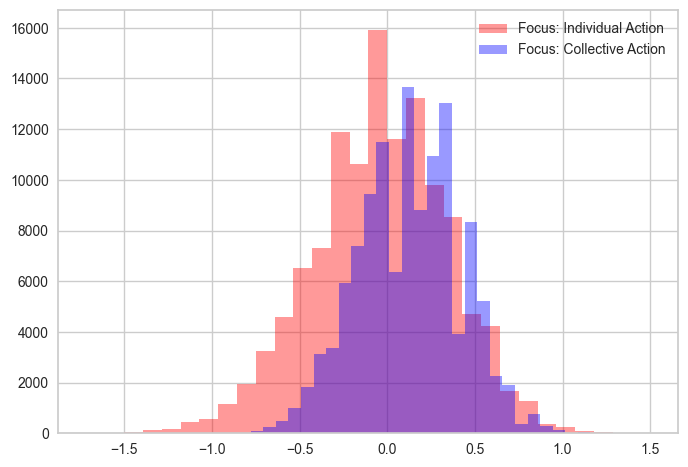

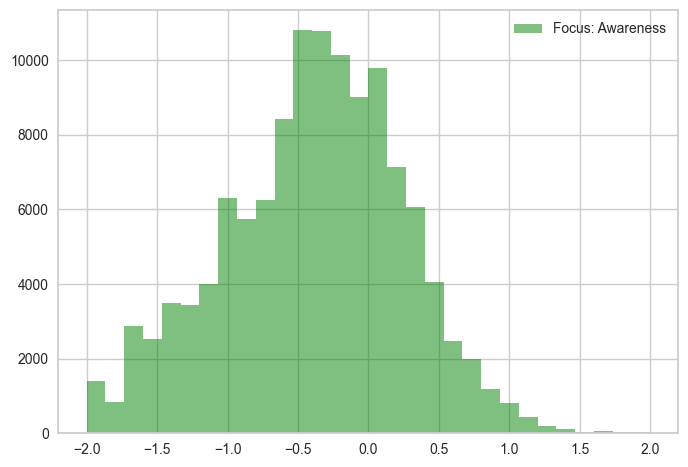

In [97]:
survey_df['score_individual_action'].hist(bins=30, label="Focus: Individual Action", alpha=0.4, color="red")
survey_df['score_collective_action'].hist(bins=30, label="Focus: Collective Action", alpha=0.4, color="blue")
plt.legend()
plt.show()
survey_df['score_awareness'].hist(bins=30, label="Focus: Awareness", alpha=0.5, color="green")
plt.legend()

#### Fossil dependence data (Fossil Rent as Fraction of GDP)

In [12]:
# Add mapper df
survey_iso2_codes = pd.Series(survey_df['country_iso2'].unique())
survey_country_names = pd.Series(survey_data_raw_df['country'].unique()).apply(lambda st: st.split("-")[1])
survey_wb_economy_codes = wb.economy.coder(survey_country_names)
country_code_df = pd.DataFrame({'country_iso2': survey_iso2_codes, 'country_iso3': survey_wb_economy_codes})

In [13]:
fuel_rents_wb_indicators = [
  'NY.GDP.NGAS.RT.ZS', # Rent from Gas as Percentage of GDP
  'NY.GDP.COAL.RT.ZS', # Rent from Coal as Percentage of GDP
  'NY.GDP.PETR.RT.ZS', # Rent from Petroleum as Percentage of GDP
]
gdp_us_current_wb_indicator = 'NY.GDP.PCAP.CD' # GDP per Capita by Current US$

# Fetch data from world bank (Fossil Rents and GDP data)
fossil_dependence_df = wb.data.DataFrame(
  fuel_rents_wb_indicators + [gdp_us_current_wb_indicator],
  economy=country_code_df['country_iso3'].unique(), 
  time=survey_df['year'].unique(),
  numericTimeKeys=True,
  skipBlanks=True,
  columns='series'
).reset_index()

# Rents are in percent form. Normalize to [0-1]
fossil_dependence_df[fuel_rents_wb_indicators] /= 100
# Sum fossil rent indicators (fraction Fossil Rent of total GDP)
fossil_dependence_df['fossil_rent'] = fossil_dependence_df[['NY.GDP.NGAS.RT.ZS', 'NY.GDP.COAL.RT.ZS', 'NY.GDP.PETR.RT.ZS']].sum(axis=1)
fossil_dependence_df['fossil_rent_log10'] = np.log10(fossil_dependence_df['fossil_rent'] + 1)

# Log GDP per Capita to reduce skew, as done in Knight (2018)
fossil_dependence_df['gdp_log10'] = np.log10(fossil_dependence_df[gdp_us_current_wb_indicator])

### Merge Datasets

In [14]:
# Add iso2 country codes to wb data
fossil_dependence_df = pd.DataFrame.merge(fossil_dependence_df, country_code_df, left_on='economy', right_on='country_iso3')

# merge survey and wb data by time and country (for a year and country, each respondent gets the same fossil dependence scores)
merged_df = pd.DataFrame.merge(fossil_dependence_df, survey_df, left_on=['time', "country_iso2"], right_on=['year', 'country_iso2'])

## Analysis

### Variables

- **Independent Variable**: Fossil fuel dependence
- **Dependent Variable**: Support for individual vs collective action?
- **Control**: Climate change awareness

### Identify Awareness, Public, and Collective Action variables

In [15]:
# Parameters relevant for later analysis.
most_params = ['NY.GDP.COAL.RT.ZS', 'NY.GDP.NGAS.RT.ZS',	'NY.GDP.PETR.RT.ZS', 'fossil_rent'] \
                + ['fossil_rent_log10', 'NY.GDP.PCAP.CD', 'gdp_log10'] \
                + ['score_awareness'] \
                + ['score_indiv_minus_collective'] \
                + list(awareness_questions_weights.keys()) \
                + list(propaganda_questions_weights.keys()) \
                + list(collective_action_questions_weights.keys())
# Aggregated Scores
score_cols = ['score_awareness', 'score_individual_action', 'score_collective_action', 'score_indiv_minus_collective']
groupby_params = ['country_iso2', 'year']


In [16]:
# We could multiply the regional weight factors but it has next to no impact (doesn't make a difference though and the code is less readable)...
# adjusted = merged_df.groupby(['year', 'country_iso2']).apply(lambda x: np.ma.average(x['score_awareness'], weights=x['regional_weight_factor'], axis=0))
# adjusted

# Aggregate responses by country and year (because we don't have more fine-grained data on the economy-side).
aggregated_scores = merged_df.groupby(groupby_params)[most_params].agg(np.nanmean)
# Add fossil rent for country and year
aggregated_scores['fossil_rent'] = merged_df.groupby(groupby_params)['fossil_rent'].first()
# Drop values with missing target awareness
aggregated_scores = aggregated_scores[aggregated_scores['score_awareness'].notna()]
aggregated_scores = aggregated_scores.reset_index()

The following shows the Development of several Indicators assessed to generate an aggregated "climate awareness" score.

In [ ]:
years = survey_df['year'].unique().sort_values()
for question in (list(awareness_questions_weights.keys())):
  mean_by_year = survey_df.groupby('year')[question].mean()
  mean_by_year = mean_by_year.sort_index()
  label = column_labels[question] or question
  plt.plot(mean_by_year, label=label)

plt.title("Support for statements about environment")
plt.xlabel("year (1993, 2000, 2010, 2020)")
plt.ylabel("Average, normalized response (-2 to 2)")
# help(plt.legend)
plt.legend(loc=(0.1,0.45))

### Correlation between different Indicators

In [ ]:
# Show all correlation grid with pearson coefficients with pval < 0.05

aggregated_scores.corr(method=lambda x,y: stats.pearsonr(x,y)[0] if stats.pearsonr(x,y)[1] < 0.05 else np.nan)[
  ['NY.GDP.COAL.RT.ZS', 'NY.GDP.NGAS.RT.ZS', 'NY.GDP.PETR.RT.ZS', 'fossil_rent', 'fossil_rent_log10', 'NY.GDP.PCAP.CD', 'gdp_log10']]

### Comparison of various other statistical methods

In [103]:
# The following assess different models to explain awareness by fossil rent and logged gdp.
# The results show that there is no correlation (R² value below 0 for all tests).

# Pycaret is a tool to that can compare statistical models and all sorts of nice things, e.g. visualizations.
# In the following a set of models is assessed.
import pycaret.regression as reg

exp1 = reg.setup(
  data=aggregated_scores[['fossil_rent_log10', 'score_awareness', 'gdp_log10']], # log(GDP per capita) is included as a control variable, as done by Knight (2018).
  target='score_awareness',
)

# Don't use more than 12 seconds for evaluating a model.
model = reg.compare_models(budget_time=0.2)
# Show interactive dashboard about best model (e.g. prediction error and feature importance).
# reg.evaluate_model(model)

,Description,Value
0,Session id,1627
1,Target,score_awareness
2,Target type,Regression
3,Original data shape,"(100, 3)"
4,Transformed data shape,"(100, 3)"
5,Transformed train set shape,"(70, 3)"
6,Transformed test set shape,"(30, 3)"
7,Numeric features,2
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.2622,0.0968,0.3061,-0.2126,0.2031,3.3169,0.0160
en,Elastic Net,0.2622,0.0968,0.3061,-0.2126,0.2031,3.3169,0.0150
llar,Lasso Least Angle Regression,0.2622,0.0968,0.3061,-0.2126,0.2031,3.3169,0.0280
br,Bayesian Ridge,0.2623,0.0968,0.3061,-0.2132,0.2032,3.3188,0.0180
ridge,Ridge Regression,0.2648,0.0983,0.3082,-0.2272,0.2048,3.3659,0.0260
omp,Orthogonal Matching Pursuit,0.2647,0.0983,0.3083,-0.2275,0.2048,3.3650,0.0170
lr,Linear Regression,0.2742,0.1005,0.3121,-0.2817,0.2082,3.4098,0.5110
lar,Least Angle Regression,0.2742,0.1005,0.3121,-0.2817,0.2082,3.4098,0.0210
huber,Huber Regressor,0.2684,0.1019,0.3134,-0.2822,0.2090,3.1827,0.0200
rf,Random Forest Regressor,0.2591,0.1049,0.3147,-0.3422,0.2146,3.5899,0.0950


In [104]:
def plot_regression(df, y_name, x_name, xlabel="", ylabel="", points_label=""):


    exp1 = reg.setup(
        data=df[[x_name] + [y_name]],
        target=y_name,
    )
    # Robust regression
    model = reg.create_model('lr')

    # Generate x-values for plotting
    x_plot = np.linspace(df[x_name].min(), df[x_name], 100)

    # Calculate the predicted y-values
    df_new = pd.DataFrame(columns=[x_name])
    df_new[x_name] = x_plot
    y_plot = reg.predict_model(model, data=df_new)
    
    # Plot the data, regression line, and confidence interval
    plt.scatter(df[y_name], df[x_name], label=points_label)
    plt.plot(x_plot, y_plot, label='Regression line', color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"p-value = {reg.pvalue:.4f}")
    plt.legend()
    plt.grid()
    plt.show()



plot_regression(
    aggregated_scores,
    y_name='science_solves_env_problems',
    x_name='fossil_rent_log10',
    xlabel = "Fossil Rent as fraction of GDP (log10)",
    ylabel = "Agree - Disagree: Science will solve environmental problems [-2,2]",
    points_label="Year-country observations",
)

,NY.GDP.COAL.RT.ZS,NY.GDP.NGAS.RT.ZS,NY.GDP.PETR.RT.ZS,fossil_rent,NY.GDP.PCAP.CD,gdp_logged
NY.GDP.COAL.RT.ZS,1.000000,NaN,NaN,0.243200,NaN,NaN
NY.GDP.NGAS.RT.ZS,NaN,1.000000,0.763436,0.843501,NaN,NaN
NY.GDP.PETR.RT.ZS,NaN,0.763436,1.000000,0.976692,NaN,NaN
fossil_rent,0.243200,0.843501,0.976692,1.000000,NaN,NaN
NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,1.000000,0.868057
gdp_logged,NaN,NaN,NaN,NaN,0.868057,1.000000
score_awareness,NaN,NaN,NaN,NaN,NaN,NaN
score_indiv_minus_collective,NaN,NaN,NaN,NaN,NaN,NaN
science_solves_env_problems,-0.277489,NaN,-0.272741,-0.302427,0.516953,0.632031
support_indiv_pay_more,NaN,NaN,NaN,NaN,-0.308576,-0.274579


In [ ]:
# The following assess different models to explain awareness by fossil rent and logged gdp.,
# The results show that there is no correlation (R² value below 0 for all tests).,

# Pycaret is a tool to that can compare statistical models and all sorts of nice things, e.g. visualizations.,
# In the following a set of models is assessed.,

exp1 = reg.setup(
  data=aggregated_scores[['fossil_rent', 'gdp_log10', 'science_solves_env_problems']], # log(GDP per capita) is included as a control variable, as done by Knight (2018).
  target='science_solves_env_problems',
  # numeric_features=['score_awareness', 'fossil_rent'],,
)

# Don't use more than 12 seconds for evaluating a model.,
model = reg.compare_models(budget_time=0.2),
# Show interactive dashboard about best model (e.g. prediction error and feature importance).,
# reg.evaluate_model(model)"


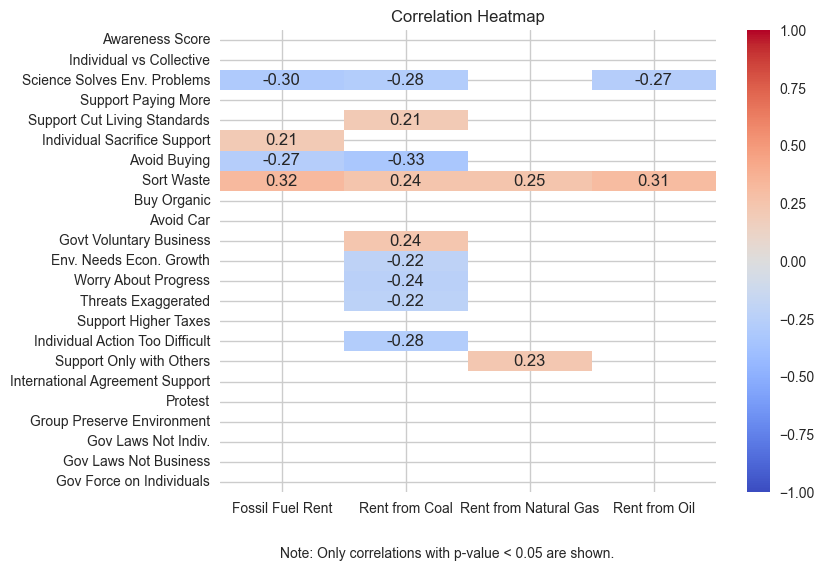

In [105]:
label_maper = {
    'NY.GDP.COAL.RT.ZS': 'Rent from Coal',
    'NY.GDP.NGAS.RT.ZS': 'Rent from Natural Gas',
    'NY.GDP.PETR.RT.ZS': 'Rent from Oil',
    'fossil_rent': 'Fossil Fuel Rent',
    'NY.GDP.PCAP.CD': 'GDP per Capita',
    'gdp_logged': 'Logged GDP',
    'score_awareness': 'Awareness Score',
    'score_indiv_minus_collective': 'Individual vs Collective',
    'science_solves_env_problems': 'Science Solves Env. Problems',
    'support_indiv_pay_more': 'Support Paying More',
    'support_cut_living_standards': 'Support Cut Living Standards',
    'indiv_support_sacrifice': 'Individual Sacrifice Support',
    'indiv_avoid_buying': 'Avoid Buying',
    'indiv_sort_waste': 'Sort Waste',
    'indiv_buy_organic': 'Buy Organic',
    'indiv_avoid_car': 'Avoid Car',
    'gov_voluntary_business': 'Govt Voluntary Business',
    'env_needs_econ_growth': 'Env. Needs Econ. Growth',
    'ppl_worry_too_much_progress_harms_env': 'Worry About Progress',
    'threats_exaggerated': 'Threats Exaggerated',
    'support_pay_higher_taxes': 'Support Higher Taxes',
    'indiv_action_too_difficult': 'Individual Action Too Difficult',
    'support_only_with_others': 'Support Only with Others',
    'internation_agreement_support': 'International Agreement Support',
    'protest': 'Protest',
    'member_group_preserve_env': 'Group Preserve Environment',
    'gov_laws_not_indiv': 'Gov Laws Not Indiv.',
    'gov_laws_not_business': 'Gov Laws Not Business',
    'gov_force_indiv': 'Gov Force on Individuals'
}


correlation_matrix = aggregated_scores.corr(
    method=lambda x, y: sp.stats.pearsonr(x, y)[0] if sp.stats.pearsonr(x, y)[1] < 0.05 else np.nan
)[
    ['fossil_rent', 'NY.GDP.COAL.RT.ZS', 'NY.GDP.NGAS.RT.ZS', 'NY.GDP.PETR.RT.ZS']
]

correlation_matrix = correlation_matrix.rename(columns=label_maper, index=label_maper)
correlation_matrix = correlation_matrix.iloc[6:, :]  

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot= True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f')
plt.title("Correlation Heatmap")
plt.figtext(0.2, 0, 'Note: Only correlations with p-value < 0.05 are shown.', fontsize=10)
plt.show()